# Installing packages

In [7]:
!pip install datasets -q

In [8]:
!pip install transformers -q

In [9]:
!pip install numba -q 

In [10]:
!pip install wandb -q

In [11]:
!pip install torchmetrics -q

# Loading packages

In [12]:
import os
import random
import shutil
import wandb
import matplotlib.pyplot as plt
import math 
import torch
import torch.nn as nn
import torch.nn.functional as F
import collections
import numpy as np

from tqdm import tqdm
from torch import nn as nn
from torch.nn import MSELoss, SmoothL1Loss, L1Loss
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics import Dice
from transformers import SegformerFeatureExtractor
from PIL import Image
from numba import cuda 
from google.colab import drive
from statistics import mean
from typing import Optional

# Logging to drive

In [13]:
drive = drive.mount('/content/drive')

Mounted at /content/drive


# Downloanding Dataset

In [14]:
!rm -rf /content/Hurricane_Harvey/

In [15]:
%%shell
mkdir Hurricane_Harvey 
mkdir Hurricane_Harvey/rasters Hurricane_Harvey/vectors 
gsutil -m cp -n -r gs://geoengine-dataset-houston-uav/rasters/raw Hurricane_Harvey/rasters/ 
gsutil -m cp -n -r gs://geoengine-dataset-houston-uav/vectors/random-split-_2022_11_17-22_35_45/ Hurricane_Harvey/vectors/

Copying gs://geoengine-dataset-houston-uav/rasters/raw/10170.tif...
Copying gs://geoengine-dataset-houston-uav/rasters/raw/10171.tif...
Copying gs://geoengine-dataset-houston-uav/rasters/raw/10172.tif...
Copying gs://geoengine-dataset-houston-uav/rasters/raw/10184.tif...
Copying gs://geoengine-dataset-houston-uav/rasters/raw/10174.tif...
Copying gs://geoengine-dataset-houston-uav/rasters/raw/10300.tif...
Copying gs://geoengine-dataset-houston-uav/rasters/raw/10566.tif...
Copying gs://geoengine-dataset-houston-uav/rasters/raw/10810.tif...
Copying gs://geoengine-dataset-houston-uav/rasters/raw/10812.tif...
Copying gs://geoengine-dataset-houston-uav/rasters/raw/10808.tif...
Copying gs://geoengine-dataset-houston-uav/rasters/raw/6416.tif...
Copying gs://geoengine-dataset-houston-uav/rasters/raw/6414.tif...
Copying gs://geoengine-dataset-houston-uav/rasters/raw/10814.tif...
Copying gs://geoengine-dataset-houston-uav/rasters/raw/6411.tif...
Copying gs://geoengine-dataset-houston-uav/rasters/

# Division to train / test and moving data

Splitting data into directories in following manner:
 --processed
   -- training
      --images
      --annotation
   -- validation
      --images
      --annotation
   -- test
      --images

In [16]:
PATH = '/content/Hurricane_Harvey'
MASKS_path = '/vectors/random-split-_2022_11_17-22_35_45/Masks'
IMAGES_path = '/rasters/raw'
val_size = 0.2
SEED = 666

random.seed(SEED)

remove folder if exists

In [17]:
def create_dir_if_not_exists(PATH):
  if not os.path.isdir(PATH):
    os.mkdir(PATH)

In [18]:
# find names of all training images
all_annotated_images = []
for i in os.listdir(PATH + MASKS_path):
  all_annotated_images.append(i.split(".")[0])

# take 20% of these images as validation set
k = math.floor(len(all_annotated_images)*val_size)
random.shuffle(all_annotated_images)
val_images = all_annotated_images[:k]
train_images = all_annotated_images[k:]

# copy files to processed folder in a way it was described
create_dir_if_not_exists(PATH + '/processed')
create_dir_if_not_exists(PATH + '/processed/training')
create_dir_if_not_exists(PATH + '/processed/training/images')
create_dir_if_not_exists(PATH + '/processed/training/annotation')
create_dir_if_not_exists(PATH + '/processed/validation')
create_dir_if_not_exists(PATH + '/processed/validation/images')
create_dir_if_not_exists(PATH + '/processed/validation/annotation')
create_dir_if_not_exists(PATH + '/processed/test')
create_dir_if_not_exists(PATH + '/processed/test/images')

# copying data
for i in tqdm(os.listdir(PATH + IMAGES_path)):
  if 'tif' not in i:
    continue
  image_number = i.split(".")[0]
  if(image_number in train_images):
    # copying img
    src_path = PATH + IMAGES_path + "/" + image_number + '.tif'
    dst_path = PATH + "/processed/training/images/" + image_number + '.tif'
    shutil.copy(src_path, dst_path)
    # copying anotaion
    src_path = PATH + MASKS_path + "/" + image_number + '.png'
    dst_path = PATH + "/processed/training/annotation/" + image_number + '.png'
    shutil.copy(src_path, dst_path)

  elif(image_number in val_images):
    # copying img
    src_path = PATH + IMAGES_path + "/" + image_number + '.tif'
    dst_path = PATH + "/processed/validation/images/" + image_number + '.tif'
    shutil.copy(src_path, dst_path)
    # copying anotaion
    src_path = PATH + MASKS_path + "/" + image_number + '.png'
    dst_path = PATH + "/processed/validation/annotation/" + image_number + '.png'
    shutil.copy(src_path, dst_path)

  else : 
    # copying img
    src_path = PATH + IMAGES_path + "/" + image_number + '.tif'
    dst_path = PATH + "/processed/test/images/" + image_number + '.tif'
    shutil.copy(src_path, dst_path)


100%|██████████| 375/375 [00:01<00:00, 258.13it/s]


# Dataset creation


## Dataset class

In [19]:
# TODO add handling test set

class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, feature_extractor, type_=None):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            type_ (string) : must belong to ['training','validation','test'] 
        """
        assert type_ in ['training','validation','test'], 'Specify dataset type'
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.type_ = type_

        self.img_dir = os.path.join(self.root_dir, self.type_, "images")
        if self.type_ != "test":
          self.ann_dir = os.path.join(self.root_dir, self.type_, "annotation")
        
        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
          image_file_names.extend(files)
        self.images = sorted(image_file_names)
        
        # read annotations
        annotation_file_names = []
        if self.type_ != "test":
          for root, dirs, files in os.walk(self.ann_dir):
            annotation_file_names.extend(files)
          self.annotations = sorted(annotation_file_names)

          assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        
        image = Image.open(os.path.join(self.img_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.ann_dir, self.annotations[idx]))

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

## Loading Dataset to class

In [20]:
#do_normalize = False
do_normalize = True
root_dir = PATH + '/processed'

In [21]:
### uncoment one of the Segformer preprocessing functions 


feature_extractor = SegformerFeatureExtractor(do_normalize = do_normalize)
#feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/mit-b3")
#feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/mit-b0")

train_dataset = SemanticSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, type_="training")
valid_dataset = SemanticSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, type_="validation")

/usr/local/lib/python3.8/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


Print feature extractor to understand whats happening inside

In [22]:
feature_extractor

SegformerFeatureExtractor {
  "do_normalize": true,
  "do_reduce_labels": false,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "SegformerFeatureExtractor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 512,
    "width": 512
  }
}

## Loading dataset to dataloader

In [23]:
batch_size = 4

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)

# Data exploration

## Counting classes and resolutions

In [24]:
# when you dont wont to run next cells because of time constraint just run this 
num_of_classes = 27
weight_tensor = torch.tensor([3.8343e-01, 3.5192e-01, 1.4112e+01, 8.1891e+00, 2.2875e+01, 1.3134e-01,
        2.9822e-01, 3.6595e+02, 5.6142e+01, 8.5381e+02, 1.0672e+02, 3.4570e+03,
        2.3174e+02, 1.4790e+02, 8.0237e-01, 3.4351e+01, 4.1041e+00, 4.2639e+02,
        2.3148e+02, 4.0821e+00, 1.1664e+02, 3.3037e+01, 5.8866e-01, 8.9006e-01,
        1.9132e-01, 5.0316e+03, 2.2450e+00])

Count number of pixels in each class

In [ ]:
classes = set()
counter_classes = collections.Counter()

for i in tqdm(os.listdir(PATH + MASKS_path)):
  mask = Image.open(PATH + MASKS_path + "/" +i)
  np_frame = np.array(mask.getdata())
  tmp_counter = collections.Counter(np_frame)
  counter_classes = counter_classes + tmp_counter

100%|██████████| 299/299 [13:53<00:00,  2.79s/it]


In [ ]:
num_of_classes = len(counter_classes)
sorted(counter_classes.items())

[(0, 363061019),
 (1, 395572361),
 (2, 9864356),
 (3, 16999364),
 (4, 6085755),
 (5, 1059877042),
 (6, 466797435),
 (7, 380408),
 (8, 2479592),
 (9, 163044),
 (10, 1304406),
 (11, 40269),
 (12, 600702),
 (13, 941241),
 (14, 173496681),
 (15, 4052584),
 (16, 33919582),
 (17, 326484),
 (18, 601397),
 (19, 34102558),
 (20, 1193530),
 (21, 4213671),
 (22, 236483694),
 (23, 156403456),
 (24, 727639373),
 (25, 27667),
 (26, 62008873)]

## Computing weights

Compute weights of classes according to https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/ 

In [ ]:
n_samples = sum(counter_classes.values())

weight_tensor = torch.zeros(num_of_classes)
for i in range(num_of_classes):
  weight_tensor[i] = n_samples / ( num_of_classes *  counter_classes[i])

In [ ]:
weight_tensor

tensor([3.8343e-01, 3.5192e-01, 1.4112e+01, 8.1891e+00, 2.2875e+01, 1.3134e-01,
        2.9822e-01, 3.6595e+02, 5.6142e+01, 8.5381e+02, 1.0672e+02, 3.4570e+03,
        2.3174e+02, 1.4790e+02, 8.0237e-01, 3.4351e+01, 4.1041e+00, 4.2639e+02,
        2.3148e+02, 4.0821e+00, 1.1664e+02, 3.3037e+01, 5.8866e-01, 8.9006e-01,
        1.9132e-01, 5.0316e+03, 2.2450e+00])

Counting number of resolutions of data

In [ ]:
counter = {}
for i in tqdm(os.listdir(PATH + IMAGES_path)):
  if ".tif" not in i:
    continue
  image = Image.open(PATH + IMAGES_path + "/" + i)
  size = str(image.size[0])+"x"+str(image.size[1])
  counter[size] = counter.get(size, 0) + 1

100%|██████████| 375/375 [00:00<00:00, 4700.87it/s]


In [ ]:
counter

{'4592x3072': 111, '4000x3000': 263}

## Sanity check on data

In [ ]:
encoded_inputs = train_dataset[1]

In [ ]:
encoded_inputs["pixel_values"].shape

torch.Size([3, 512, 512])

In [ ]:
encoded_inputs["labels"].shape

torch.Size([512, 512])

In [ ]:
encoded_inputs["labels"]

tensor([[0, 0, 0,  ..., 1, 1, 0],
        [0, 0, 0,  ..., 1, 1, 0],
        [0, 0, 0,  ..., 1, 1, 0],
        ...,
        [6, 6, 6,  ..., 6, 6, 6],
        [6, 6, 6,  ..., 6, 6, 6],
        [6, 6, 6,  ..., 6, 6, 6]])

In [ ]:
encoded_inputs["labels"].squeeze().unique()

tensor([ 0,  1,  3,  4,  5,  6,  8, 10, 11, 13, 26])

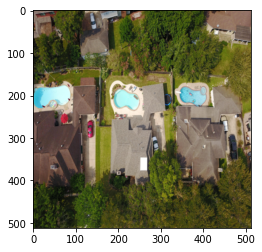

In [ ]:
plt.imshow(encoded_inputs["pixel_values"].permute(1, 2, 0))

# Model creation

In [109]:
from transformers import SegformerForSemanticSegmentation

model_name = "nvidia/mit-b0"
# define model
model = SegformerForSemanticSegmentation.from_pretrained(model_name,
                                                         num_labels=num_of_classes)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_fuse.weight', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.3.proj.weight', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.num_batches_tracked', 'dec

# Loss implementation

## Dice loss

In [26]:
def one_hot_encoding(target,number_of_classes):
  batch_size_tmp = target.shape[0]
  new_true = torch.zeros((target.shape[0],
                          number_of_classes,
                          target.shape[1],
                          target.shape[2]))

  for b in range(batch_size_tmp):
    annotation = target[b]
    for i in range(number_of_classes):
      one_hot = torch.zeros((target.shape[1],target.shape[2]))
      one_hot[annotation==i] = 1
      new_true[b,i] = one_hot
  return new_true

In [27]:
def compute_per_channel_dice(input, target, epsilon=1e-5, ignore_index=None, weight=None):
    # assumes that input is a normalized probability
    target = one_hot_encoding(target,num_of_classes)
    
    # input and target shapes must match
    assert input.size() == target.size(), "'input' and 'target' must have the same shape"

    # mask ignore_index if present
    if ignore_index is not None:
        mask = target.clone().ne_(ignore_index)
        mask.requires_grad = False

        input = input.to(device) * mask.to(device)
        target = target.to(device) * mask.to(device)

    input = torch.flatten(input)
    target = torch.flatten(target)
    
    target = target.float()
    # Compute per channel Dice Coefficient
    intersect = (input * target).sum(-1)
    if weight is not None:
        intersect = weight * intersect

    denominator = (input + target).sum(-1)
    return 2. * intersect / denominator.clamp(min=epsilon)

In [28]:
class DiceLoss(nn.Module):
    """Computes Dice Loss, which just 1 - DiceCoefficient described above.
    Additionally allows per-class weights to be provided.
    """

    def __init__(self, epsilon=1e-5, weight=None, ignore_index=None, sigmoid_normalization=True,
                 skip_last_target=False):
        super(DiceLoss, self).__init__()
        self.epsilon = epsilon
        self.register_buffer('weight', weight)
        self.ignore_index = ignore_index
        # The output from the network during training is assumed to be un-normalized probabilities and we would
        # like to normalize the logits. Since Dice (or soft Dice in this case) is usually used for binary data,
        # normalizing the channels with Sigmoid is the default choice even for multi-class segmentation problems.
        # However if one would like to apply Softmax in order to get the proper probability distribution from the
        # output, just specify sigmoid_normalization=False.
        if sigmoid_normalization:
            self.normalization = nn.Sigmoid()
        else:
            self.normalization = nn.Softmax(dim=1)
        # if True skip the last channel in the target
        self.skip_last_target = skip_last_target

    def forward(self, input, target):
        # get probabilities from logits
        input = self.normalization(input)
        if self.weight is not None:
            weight = Variable(self.weight, requires_grad=False)
        else:
            weight = None

        if self.skip_last_target:
            target = target[:, :-1, ...]

        per_channel_dice = compute_per_channel_dice(input, target, epsilon=self.epsilon, ignore_index=self.ignore_index,
                                                    weight=weight)
        # Average the Dice score across all channels/classes
        return torch.mean(1. - per_channel_dice)


## Focal loss

In [29]:
# based on:
# https://github.com/zhezh/focalloss/blob/master/focalloss.py

class FocalLoss(nn.Module):
    r"""Criterion that computes Focal loss.

    According to [1], the Focal loss is computed as follows:

    .. math::

        \text{FL}(p_t) = -\alpha_t (1 - p_t)^{\gamma} \, \text{log}(p_t)

    where:
       - :math:`p_t` is the model's estimated probability for each class.


    Arguments:
        alpha (float): Weighting factor :math:`\alpha \in [0, 1]`.
        gamma (float): Focusing parameter :math:`\gamma >= 0`.
        reduction (Optional[str]): Specifies the reduction to apply to the
         output: ‘none’ | ‘mean’ | ‘sum’. ‘none’: no reduction will be applied,
         ‘mean’: the sum of the output will be divided by the number of elements
         in the output, ‘sum’: the output will be summed. Default: ‘none’.

    Shape:
        - Input: :math:`(N, C, H, W)` where C = number of classes.
        - Target: :math:`(N, H, W)` where each value is
          :math:`0 ≤ targets[i] ≤ C−1`.

    Examples:
        >>> N = 5  # num_classes
        >>> loss = tgm.losses.FocalLoss(alpha=0.5, gamma=2.0, reduction='mean')
        >>> input = torch.randn(1, N, 3, 5, requires_grad=True)
        >>> target = torch.empty(1, 3, 5, dtype=torch.long).random_(N)
        >>> output = loss(input, target)
        >>> output.backward()

    References:
        [1] https://arxiv.org/abs/1708.02002
    """

    def __init__(self, alpha: float, gamma: Optional[float] = 2.0,
                 reduction: Optional[str] = 'none') -> None:
        super(FocalLoss, self).__init__()
        self.alpha: float = alpha
        self.gamma: Optional[float] = gamma
        self.reduction: Optional[str] = reduction
        self.eps: float = 1e-6

    def forward(
            self,
            input: torch.Tensor,
            target: torch.Tensor) -> torch.Tensor:
        if not torch.is_tensor(input):
            raise TypeError("Input type is not a torch.Tensor. Got {}"
                            .format(type(input)))
        if not len(input.shape) == 4:
            raise ValueError("Invalid input shape, we expect BxNxHxW. Got: {}"
                             .format(input.shape))
        if not input.shape[-2:] == target.shape[-2:]:
            raise ValueError("input and target shapes must be the same. Got: {}"
                             .format(input.shape, input.shape))
        if not input.device == target.device:
            raise ValueError(
                "input and target must be in the same device. Got: {}" .format(
                    input.device, target.device))
        # compute softmax over the classes axis
        input_soft = F.softmax(input, dim=1) + self.eps

        # create the labels one hot tensor
        target_one_hot = one_hot_encoding(target,27).to(device)

        # compute the actual focal loss
        weight = torch.pow(1. - input_soft, self.gamma)
        focal = -self.alpha * weight * torch.log(input_soft)
        loss_tmp = torch.sum(target_one_hot * focal, dim=1)

        loss = -1
        if self.reduction == 'none':
            loss = loss_tmp
        elif self.reduction == 'mean':
            loss = torch.mean(loss_tmp)
        elif self.reduction == 'sum':
            loss = torch.sum(loss_tmp)
        else:
            raise NotImplementedError("Invalid reduction mode: {}"
                                      .format(self.reduction))
        return loss

# Training model

In [112]:
# Global params
max_epochs = 60
project_name = "FloodNet_SegFormer"

## Loss : Cross entropy / Weights: no

In [ ]:
model = SegformerForSemanticSegmentation.from_pretrained(model_name,
                                                         num_labels=num_of_classes)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_fuse.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.bias', 'decode_head.

In [ ]:
# Path to save model
PATH_to_save_model = "/content/drive/MyDrive/FDL/Group_work/SegFormer_v1/"

# Setting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loss
cross_entropy = torch.nn.CrossEntropyLoss()

# Setting calculation of dice coef
dice_coef = Dice(average='micro',
                 zero_division = 0.00001, 
                 ignore_index = 0)

# Normalization used for Cross entropy
normalization = torch.nn.Softmax(dim=1)

# Learning _ rate
lr = 0.00005

# Epochs
epochs = max_epochs

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), 
                              lr=lr)
# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(optimizer, 
                                 mode = 'max',
                                 factor=0.1,
                                 threshold=0.001, 
                                 patience=10)

In [ ]:
# Complete the hyperparams dict with the infos of your run
hyperparams = {"Model type" : model_name,
               "Batch size": batch_size,
               "Learning rate": lr,
               "Epochs": epochs}
               
# Init the WandB run with hyperparams
wandb.init(config=hyperparams,
           name = "b0 / norm / ce / no weight",
           project=project_name)

In [ ]:
#move model to GPU
model.to(device)

num_batches_train = math.ceil(len(train_dataloader))
num_batches_val = math.ceil(len(valid_dataloader))
best_dice = 0 

In [ ]:
for epoch in range(epochs):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   # TRAINING
   model.train()
   total_train_dice = []
   total_val_dice = []
   for idx, batch in enumerate(tqdm(train_dataloader)):

        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values,labels=labels)
        loss_mse, logits = outputs.loss, outputs.logits
        logits = outputs.logits
        
        # calculating loss
        predicted = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = normalization(predicted)

        labels_for_ce = one_hot_encoding(labels, num_of_classes).to(device)
        
        loss = cross_entropy(predicted, labels_for_ce)

        loss.backward()
        optimizer.step()
        
        # calculating additional metrics
        with torch.no_grad():
          predicted = predicted.argmax(dim=1)
          dice_coef_value = dice_coef(predicted.detach().cpu(),labels.detach().cpu())
          
          total_train_dice.append(dice_coef_value.item())

        wandb.log({"train_mse":loss_mse.item(),
                   "train_loss":loss.item(),
                   "train_dice_coef":dice_coef_value.item(),
                   "step2":num_batches_train*epoch+idx+1})
        
   # VALIDATION
   model.eval()
   with torch.no_grad():
       for idx, batch in enumerate(tqdm(valid_dataloader)):
           # get the inputs;
           pixel_values = batch["pixel_values"].to(device)
           labels = batch["labels"].to(device)
          
           # prediction
           outputs = model(pixel_values=pixel_values,labels=labels)
           loss_mse, logits = outputs.loss, outputs.logits

           upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
           predicted = normalization(upsampled_logits)
           predicted_class = upsampled_logits.argmax(dim=1)
           
           labels_for_ce = one_hot_encoding(labels,num_of_classes).to(device)
           
           loss = cross_entropy(predicted.detach(), labels.detach())
           
           # Computing additional metrics
           dice_coef_value = dice_coef(predicted_class.detach().cpu(),labels.detach().cpu())
           
           total_val_dice.append(dice_coef_value.item())

           wandb.log({"val_mse":loss_mse.item(),
                      "val_loss":loss.item(),
                      "val_dice_coef":dice_coef_value.item(),
                      "step2":num_batches_val*epoch+idx+1})
           
   # LOGGING PER BATCH INFO           
   wandb.log({"train_per_epoch_dice":mean(total_train_dice),
              "val_per_epoch_dice":mean(total_val_dice)})
   
   # Saving best model
   if mean(total_val_dice) > best_dice:
     best_dice = mean(total_val_dice)
     PATH_to_model = PATH_to_save_model + "best_model.pt"
     torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict()
          }, PATH_to_model)
     
   # LR SCHEDULER
   lr_scheduler.step(mean(total_val_dice))
   print('Learning rate: {}'.format(optimizer.state_dict()['param_groups'][0]['lr']))

   # CHECKPOINTING EVERY 10 epochs
   if (epoch +1) % 10 == 0:
       PATH_to_model = PATH_to_save_model + f"model_final_{epoch+1}.pt"
       torch.save({
                  'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict()
                  }, PATH_to_model)


Epoch: 0


100%|██████████| 15/15 [00:29<00:00,  1.94s/it]


Learning rate: 5e-05
Epoch: 1


100%|██████████| 15/15 [00:29<00:00,  1.94s/it]


Learning rate: 5e-05
Epoch: 2


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


Learning rate: 5e-05
Epoch: 3


100%|██████████| 15/15 [00:29<00:00,  1.95s/it]


Learning rate: 5e-05
Epoch: 4


100%|██████████| 15/15 [00:29<00:00,  1.95s/it]


Learning rate: 5e-05
Epoch: 5


100%|██████████| 15/15 [00:29<00:00,  1.98s/it]


Learning rate: 5e-05
Epoch: 6


100%|██████████| 15/15 [00:29<00:00,  1.98s/it]


Learning rate: 5e-05
Epoch: 7


100%|██████████| 15/15 [00:28<00:00,  1.93s/it]


Learning rate: 5e-05
Epoch: 8


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


Learning rate: 5e-05
Epoch: 9


100%|██████████| 15/15 [00:28<00:00,  1.91s/it]


Learning rate: 5e-05
Epoch: 10


100%|██████████| 15/15 [00:28<00:00,  1.91s/it]


Learning rate: 5e-05
Epoch: 11


100%|██████████| 15/15 [00:28<00:00,  1.91s/it]


Learning rate: 5e-05
Epoch: 12


100%|██████████| 15/15 [00:28<00:00,  1.91s/it]


Learning rate: 5e-05
Epoch: 13


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


Learning rate: 5e-05
Epoch: 14


100%|██████████| 15/15 [00:29<00:00,  1.95s/it]


Learning rate: 5e-05
Epoch: 15


100%|██████████| 15/15 [00:29<00:00,  1.94s/it]


Learning rate: 5e-05
Epoch: 16


100%|██████████| 15/15 [00:28<00:00,  1.90s/it]


Learning rate: 5e-05
Epoch: 17


100%|██████████| 15/15 [00:28<00:00,  1.91s/it]


Learning rate: 5e-05
Epoch: 18


100%|██████████| 15/15 [00:28<00:00,  1.90s/it]


Learning rate: 5e-05
Epoch: 19


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


Learning rate: 5e-05
Epoch: 20


100%|██████████| 15/15 [00:28<00:00,  1.90s/it]


Learning rate: 5e-05
Epoch: 21


100%|██████████| 15/15 [00:28<00:00,  1.91s/it]


Learning rate: 5e-05
Epoch: 22


100%|██████████| 15/15 [00:28<00:00,  1.90s/it]


Learning rate: 5e-05
Epoch: 23


100%|██████████| 15/15 [00:28<00:00,  1.91s/it]


Learning rate: 5e-05
Epoch: 24


100%|██████████| 15/15 [00:28<00:00,  1.91s/it]


Learning rate: 5e-05
Epoch: 25


100%|██████████| 15/15 [00:28<00:00,  1.91s/it]


Learning rate: 5e-05
Epoch: 26


100%|██████████| 15/15 [00:29<00:00,  1.95s/it]


Learning rate: 5e-05
Epoch: 27


100%|██████████| 15/15 [00:29<00:00,  1.94s/it]


Learning rate: 5e-05
Epoch: 28


100%|██████████| 15/15 [00:28<00:00,  1.91s/it]


Learning rate: 5e-05
Epoch: 29


100%|██████████| 15/15 [00:28<00:00,  1.91s/it]


Learning rate: 5e-05
Epoch: 30


100%|██████████| 15/15 [00:28<00:00,  1.90s/it]


Learning rate: 5e-05
Epoch: 31


100%|██████████| 15/15 [00:28<00:00,  1.89s/it]


Learning rate: 5e-05
Epoch: 32


100%|██████████| 15/15 [00:28<00:00,  1.90s/it]


Learning rate: 5e-05
Epoch: 33


100%|██████████| 15/15 [00:28<00:00,  1.89s/it]


Learning rate: 5e-05
Epoch: 34


100%|██████████| 15/15 [00:28<00:00,  1.90s/it]


Learning rate: 5e-05
Epoch: 35


100%|██████████| 15/15 [00:28<00:00,  1.89s/it]


Learning rate: 5e-05
Epoch: 36


100%|██████████| 15/15 [00:28<00:00,  1.90s/it]


Learning rate: 5e-05
Epoch: 37


100%|██████████| 15/15 [00:28<00:00,  1.91s/it]


Learning rate: 5e-05
Epoch: 38


100%|██████████| 15/15 [00:28<00:00,  1.90s/it]


Learning rate: 5e-05
Epoch: 39


100%|██████████| 15/15 [00:28<00:00,  1.91s/it]


Learning rate: 5e-05
Epoch: 40


100%|██████████| 15/15 [00:28<00:00,  1.90s/it]


Learning rate: 5e-06
Epoch: 41


100%|██████████| 15/15 [00:28<00:00,  1.91s/it]


Learning rate: 5e-06
Epoch: 42


100%|██████████| 15/15 [00:28<00:00,  1.90s/it]


Learning rate: 5e-06
Epoch: 43


100%|██████████| 15/15 [00:28<00:00,  1.90s/it]


Learning rate: 5e-06
Epoch: 44


100%|██████████| 15/15 [00:28<00:00,  1.91s/it]


Learning rate: 5e-06
Epoch: 45


100%|██████████| 15/15 [00:28<00:00,  1.91s/it]


Learning rate: 5e-06
Epoch: 46


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


Learning rate: 5e-06
Epoch: 47


100%|██████████| 15/15 [00:28<00:00,  1.89s/it]


Learning rate: 5e-06
Epoch: 48


100%|██████████| 15/15 [00:28<00:00,  1.93s/it]


Learning rate: 5e-06
Epoch: 49


100%|██████████| 15/15 [00:28<00:00,  1.90s/it]


Learning rate: 5e-06
Epoch: 50


100%|██████████| 15/15 [00:28<00:00,  1.91s/it]


Learning rate: 5e-06
Epoch: 51


100%|██████████| 15/15 [00:28<00:00,  1.90s/it]


Learning rate: 5e-06
Epoch: 52


100%|██████████| 15/15 [00:28<00:00,  1.90s/it]


Learning rate: 5e-06
Epoch: 53


100%|██████████| 15/15 [00:28<00:00,  1.90s/it]


Learning rate: 5e-06
Epoch: 54


100%|██████████| 15/15 [00:28<00:00,  1.91s/it]


Learning rate: 5e-06
Epoch: 55


100%|██████████| 15/15 [00:28<00:00,  1.91s/it]


Learning rate: 5e-06
Epoch: 56


100%|██████████| 15/15 [00:29<00:00,  1.94s/it]


Learning rate: 5e-06
Epoch: 57


100%|██████████| 15/15 [00:29<00:00,  1.94s/it]


Learning rate: 5.000000000000001e-07
Epoch: 58


100%|██████████| 15/15 [00:29<00:00,  1.95s/it]


Learning rate: 5.000000000000001e-07
Epoch: 59


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]

Learning rate: 5.000000000000001e-07


## Loss : Cross entropy / Weghts: yes

In [ ]:
model = SegformerForSemanticSegmentation.from_pretrained(model_name,
                                                         num_labels=num_of_classes)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_fuse.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.bias', 'decode_head.

In [ ]:
# Path to save model
PATH_to_save_model = "/content/drive/MyDrive/FDL/Group_work/SegFormer_v2/"

# Setting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loss
cross_entropy = torch.nn.CrossEntropyLoss(weight = weight_tensor.to(device))

# Setting calculation of dice coef
dice_coef = Dice(average='micro',
                 zero_division = 0.00001, 
                 ignore_index = 0)

# Normalization used for Cross entropy
normalization = torch.nn.Softmax(dim=1)

# Learning _ rate
lr = 0.00005

# Epochs
epochs = max_epochs

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), 
                              lr=lr)
# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(optimizer, 
                                 mode = 'max',
                                 factor=0.1,
                                 threshold=0.001, 
                                 patience=10)

In [ ]:
# Complete the hyperparams dict with the infos of your run
hyperparams = {"Model type" : model_name,
               "Batch size": batch_size,
               "Learning rate": lr,
               "Epochs": epochs}
               
# Init the WandB run with hyperparams
wandb.init(config=hyperparams,
           name = "b0 / norm / ce / weight",
           project=project_name)

step2,▁▁▁▂▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▂▅▅▆▂▆▆▆▂▇▇▇▃▇███
train_dice_coef,▁▃▄▅▄▅▂▃▆▄▇▇▆▃▅▇▇▇▇▅▇▇▇█▇▇▇▇▇▇▅▇▆▇▇████▇
train_loss,█▇▅▄▄▄▅▄▂▄▂▃▃▄▃▂▂▂▂▃▂▂▂▁▂▂▂▂▂▂▃▁▂▂▁▁▁▁▁▂
train_mse,█▆▄▃▄▄▆▅▂▇▂▂▃▇▃▂▁▂▃▅▂▃▂▁▂▃▃▃▃▂▅▂▃▂▂▂▂▁▁▂
train_per_epoch_dice,▁▃▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█████████████████████
val_dice_coef,▁▅▄▃▅▅▇▇▇▆▇▅▇▇▆█▆█▇▆▆▆▇▅▆▆▆▆▇▇▇▇▆█▇▆█▆█▇
val_loss,█▇▄▅▃▄▂▂▂▃▂▃▂▂▂▂▂▁▂▃▃▂▂▃▃▃▂▃▂▂▂▂▂▁▂▂▁▂▁▂
val_mse,█▆▄▅▃▃▂▁▂▃▁▅▁▂▃▁▃▁▃▄▄▄▃▆▄▅▄▅▂▃▄▃▅▁▃▄▁▄▁▃
val_per_epoch_dice,▁▃▅▅▆▆▆▇▆▇▇▇▇▇██████████████████████████
step2,900
train_dice_coef,0.86575


In [ ]:
#move model to GPU
model.to(device)

num_batches_train = math.ceil(len(train_dataloader))
num_batches_val = math.ceil(len(valid_dataloader))
best_dice = 0 

In [ ]:
for epoch in range(epochs):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   # TRAINING
   model.train()
   total_train_dice = []
   total_val_dice = []
   for idx, batch in enumerate(tqdm(train_dataloader)):

        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values,labels=labels)
        loss_mse, logits = outputs.loss, outputs.logits
        logits = outputs.logits
        
        # calculating loss
        predicted = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = normalization(predicted)

        labels_for_ce = one_hot_encoding(labels, num_of_classes).to(device)
        
        loss = cross_entropy(predicted, labels_for_ce)

        loss.backward()
        optimizer.step()
        
        # calculating additional metrics
        with torch.no_grad():
          predicted = predicted.argmax(dim=1)
          dice_coef_value = dice_coef(predicted.detach().cpu(),labels.detach().cpu())
          
          total_train_dice.append(dice_coef_value.item())

        wandb.log({"train_mse":loss_mse.item(),
                   "train_loss":loss.item(),
                   "train_dice_coef":dice_coef_value.item(),
                   "step2":num_batches_train*epoch+idx+1})
        
   # VALIDATION
   model.eval()
   with torch.no_grad():
       for idx, batch in enumerate(tqdm(valid_dataloader)):
           # get the inputs;
           pixel_values = batch["pixel_values"].to(device)
           labels = batch["labels"].to(device)
          
           # prediction
           outputs = model(pixel_values=pixel_values,labels=labels)
           loss_mse, logits = outputs.loss, outputs.logits

           upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
           predicted = normalization(upsampled_logits)
           predicted_class = upsampled_logits.argmax(dim=1)
           
           labels_for_ce = one_hot_encoding(labels,num_of_classes).to(device)
           
           loss = cross_entropy(predicted.detach(), labels.detach())
           
           # Computing additional metrics
           dice_coef_value = dice_coef(predicted_class.detach().cpu(),labels.detach().cpu())
           
           total_val_dice.append(dice_coef_value.item())

           wandb.log({"val_mse":loss_mse.item(),
                      "val_loss":loss.item(),
                      "val_dice_coef":dice_coef_value.item(),
                      "step2":num_batches_val*epoch+idx+1})
           
   # LOGGING PER BATCH INFO           
   wandb.log({"train_per_epoch_dice":mean(total_train_dice),
              "val_per_epoch_dice":mean(total_val_dice)})
   
   # Saving best model
   if mean(total_val_dice) > best_dice:
     best_dice = mean(total_val_dice)
     PATH_to_model = PATH_to_save_model + "best_model.pt"
     torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict()
          }, PATH_to_model)
     
   # LR SCHEDULER
   lr_scheduler.step(mean(total_val_dice))
   print('Learning rate: {}'.format(optimizer.state_dict()['param_groups'][0]['lr']))

   # CHECKPOINTING EVERY 10 epochs
   if (epoch +1) % 10 == 0:
       PATH_to_model = PATH_to_save_model + f"model_final_{epoch+1}.pt"
       torch.save({
                  'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict()
                  }, PATH_to_model)


Epoch: 0


100%|██████████| 15/15 [00:29<00:00,  1.94s/it]


Learning rate: 5e-05
Epoch: 1


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


Learning rate: 5e-05
Epoch: 2


100%|██████████| 15/15 [00:28<00:00,  1.90s/it]


Learning rate: 5e-05
Epoch: 3


100%|██████████| 15/15 [00:28<00:00,  1.89s/it]


Learning rate: 5e-05
Epoch: 4


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


Learning rate: 5e-05
Epoch: 5


100%|██████████| 15/15 [00:28<00:00,  1.90s/it]


Learning rate: 5e-05
Epoch: 6


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


Learning rate: 5e-05
Epoch: 7


100%|██████████| 15/15 [00:29<00:00,  1.94s/it]


Learning rate: 5e-05
Epoch: 8


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


Learning rate: 5e-05
Epoch: 9


100%|██████████| 15/15 [00:28<00:00,  1.91s/it]


Learning rate: 5e-05
Epoch: 10


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


Learning rate: 5e-05
Epoch: 11


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


Learning rate: 5e-05
Epoch: 12


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


Learning rate: 5e-06
Epoch: 13


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


Learning rate: 5e-06
Epoch: 14


100%|██████████| 15/15 [00:28<00:00,  1.89s/it]


Learning rate: 5e-06
Epoch: 15


100%|██████████| 15/15 [00:28<00:00,  1.91s/it]


Learning rate: 5e-06
Epoch: 16


100%|██████████| 15/15 [00:28<00:00,  1.91s/it]


Learning rate: 5e-06
Epoch: 17


100%|██████████| 15/15 [00:28<00:00,  1.90s/it]


Learning rate: 5e-06
Epoch: 18


100%|██████████| 15/15 [00:28<00:00,  1.90s/it]


Learning rate: 5e-06
Epoch: 19


100%|██████████| 15/15 [00:28<00:00,  1.90s/it]


Learning rate: 5e-06
Epoch: 20


100%|██████████| 15/15 [00:28<00:00,  1.88s/it]


Learning rate: 5e-06
Epoch: 21


100%|██████████| 15/15 [00:28<00:00,  1.88s/it]


Learning rate: 5e-06
Epoch: 22


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


Learning rate: 5e-06
Epoch: 23


100%|██████████| 15/15 [00:28<00:00,  1.89s/it]


Learning rate: 5.000000000000001e-07
Epoch: 24


100%|██████████| 15/15 [00:28<00:00,  1.87s/it]


Learning rate: 5.000000000000001e-07
Epoch: 25


100%|██████████| 15/15 [00:28<00:00,  1.87s/it]


Learning rate: 5.000000000000001e-07
Epoch: 26


100%|██████████| 15/15 [00:28<00:00,  1.88s/it]


Learning rate: 5.000000000000001e-07
Epoch: 27


100%|██████████| 15/15 [00:28<00:00,  1.88s/it]


Learning rate: 5.000000000000001e-07
Epoch: 28


100%|██████████| 15/15 [00:28<00:00,  1.87s/it]


Learning rate: 5.000000000000001e-07
Epoch: 29


100%|██████████| 15/15 [00:28<00:00,  1.88s/it]


Learning rate: 5.000000000000001e-07
Epoch: 30


100%|██████████| 15/15 [00:27<00:00,  1.87s/it]


Learning rate: 5.000000000000001e-07
Epoch: 31


100%|██████████| 15/15 [00:28<00:00,  1.91s/it]


Learning rate: 5.000000000000001e-07
Epoch: 32


100%|██████████| 15/15 [00:28<00:00,  1.91s/it]


Learning rate: 5.000000000000001e-07
Epoch: 33


100%|██████████| 15/15 [00:29<00:00,  1.94s/it]


Learning rate: 5.000000000000001e-07
Epoch: 34


100%|██████████| 15/15 [00:28<00:00,  1.90s/it]


Learning rate: 5.000000000000001e-08
Epoch: 35


100%|██████████| 15/15 [00:28<00:00,  1.91s/it]


Learning rate: 5.000000000000001e-08
Epoch: 36


100%|██████████| 15/15 [00:28<00:00,  1.88s/it]


Learning rate: 5.000000000000001e-08
Epoch: 37


100%|██████████| 15/15 [00:28<00:00,  1.88s/it]


Learning rate: 5.000000000000001e-08
Epoch: 38


100%|██████████| 15/15 [00:28<00:00,  1.88s/it]


Learning rate: 5.000000000000001e-08
Epoch: 39


100%|██████████| 15/15 [00:28<00:00,  1.88s/it]


Learning rate: 5.000000000000001e-08
Epoch: 40


100%|██████████| 15/15 [00:28<00:00,  1.89s/it]


Learning rate: 5.000000000000001e-08
Epoch: 41


100%|██████████| 15/15 [00:28<00:00,  1.89s/it]


Learning rate: 5.000000000000001e-08
Epoch: 42


100%|██████████| 15/15 [00:28<00:00,  1.89s/it]


Learning rate: 5.000000000000001e-08
Epoch: 43


100%|██████████| 15/15 [00:28<00:00,  1.90s/it]


Learning rate: 5.000000000000001e-08
Epoch: 44


100%|██████████| 15/15 [00:28<00:00,  1.91s/it]


Learning rate: 5.000000000000001e-08
Epoch: 45


100%|██████████| 15/15 [00:28<00:00,  1.89s/it]


Learning rate: 5.000000000000002e-09
Epoch: 46


100%|██████████| 15/15 [00:27<00:00,  1.87s/it]


Learning rate: 5.000000000000002e-09
Epoch: 47


100%|██████████| 15/15 [00:28<00:00,  1.88s/it]


Learning rate: 5.000000000000002e-09
Epoch: 48


100%|██████████| 15/15 [00:28<00:00,  1.87s/it]


Learning rate: 5.000000000000002e-09
Epoch: 49


100%|██████████| 15/15 [00:28<00:00,  1.88s/it]


Learning rate: 5.000000000000002e-09
Epoch: 50


100%|██████████| 15/15 [00:28<00:00,  1.87s/it]


Learning rate: 5.000000000000002e-09
Epoch: 51


100%|██████████| 15/15 [00:28<00:00,  1.87s/it]


Learning rate: 5.000000000000002e-09
Epoch: 52


100%|██████████| 15/15 [00:28<00:00,  1.88s/it]


Learning rate: 5.000000000000002e-09
Epoch: 53


100%|██████████| 15/15 [00:28<00:00,  1.87s/it]


Learning rate: 5.000000000000002e-09
Epoch: 54


100%|██████████| 15/15 [00:28<00:00,  1.88s/it]


Learning rate: 5.000000000000002e-09
Epoch: 55


100%|██████████| 15/15 [00:28<00:00,  1.88s/it]


Learning rate: 5.000000000000002e-09
Epoch: 56


100%|██████████| 15/15 [00:28<00:00,  1.88s/it]


Learning rate: 5.000000000000002e-09
Epoch: 57


100%|██████████| 15/15 [00:28<00:00,  1.87s/it]


Learning rate: 5.000000000000002e-09
Epoch: 58


100%|██████████| 15/15 [00:27<00:00,  1.87s/it]


Learning rate: 5.000000000000002e-09
Epoch: 59


100%|██████████| 15/15 [00:28<00:00,  1.87s/it]

Learning rate: 5.000000000000002e-09


## Loss : Dice / Weights : no

In [ ]:
model = SegformerForSemanticSegmentation.from_pretrained(model_name,
                                                         num_labels=num_of_classes)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_fuse.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.bias', 'decode_head.

In [ ]:
# Path to save model
PATH_to_save_model = "/content/drive/MyDrive/FDL/Group_work/SegFormer_v3/"

# Setting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loss
dice_loss = DiceLoss(ignore_index=0)

# Setting calculation of dice coef
dice_coef = Dice(average='micro',
                 zero_division = 0.00001, 
                 ignore_index = 0)

# Normalization used for Cross entropy
normalization = torch.nn.Softmax(dim=1)

# Learning _ rate
lr = 0.00005

# Epochs
epochs = max_epochs

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), 
                              lr=lr)
# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(optimizer, 
                                 mode = 'max',
                                 factor=0.1,
                                 threshold=0.001, 
                                 patience=10)

In [ ]:
# Complete the hyperparams dict with the infos of your run
hyperparams = {"Model type" : model_name,
               "Batch size": batch_size,
               "Learning rate": lr,
               "Epochs": epochs}
               
# Init the WandB run with hyperparams
wandb.init(config=hyperparams,
           name = "b0 / norm / dice / no weight",
           project=project_name)

step2,▁▁▁▂▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▂▅▅▆▂▆▆▆▂▇▇▇▃▇███
train_dice_coef,▅▃▂▅▃▃▃▂▆▁▂▃▂▃▃▃▄█▆▃▄▃▁▄▄▂▄▄▂▂▃▃▄▅▄▂▅▄▃▂
train_loss,█▁▁▃▁▃▃▁▅▂▂▂▂▂▁▂▂▂▄▂▆▅▁▂▂▂▃▃▂▁▂▁▂▃▃▄▃▁▂▂
train_mse,▁▂▂▄▄▄▄▇▂▆▇▄▆▆▇▆▇▅▂▅▄▃▇█▅▆▇▇▆▆▅▆▇▅▅▇▆▇▆▆
train_per_epoch_dice,▅█▃▁▁▄▃▅▃▁▂▂▃▃▄▄▄▄▃▄▄▅▄▄▄▄▄▄▄▄▄▄▄▃▅▅▄▅▄▄
val_dice_coef,▅▄▁▂▂▁▄▂▆▄▂▃▁▇▄▃▃▃▂▅▄▂▄▃▄▄▂▅▂█▆▂▅▅▂▅▃▃▅▂
val_loss,█▇█▇▅▆▆▅▇▄▆▅▄▇▅▁▅▄▄▅▄▆▅█▇▄▆▅▄▆▄▅▅▄▄▆▁▅▄▄
val_mse,▁▁▄▄▃▅▄▇▅▄▅▆▇▄▅▅▇▅█▅▄▇▅▅▅▃▇▇▇▄▃▆▆▅█▄▅█▆▇
val_per_epoch_dice,▇█▅▁▂▄▆▅▂▃▄▄▄▅▅▆▆▇▆▆▇▅▇▆▅▅▆▆▆▆▇▇▇▆▆▆▇█▇▇
step2,900
train_dice_coef,0.06477


In [ ]:
#move model to GPU
model.to(device)

num_batches_train = math.ceil(len(train_dataloader))
num_batches_val = math.ceil(len(valid_dataloader))
best_dice = 0 

In [ ]:
for epoch in range(epochs):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   # TRAINING
   model.train()
   total_train_dice = []
   total_val_dice = []
   for idx, batch in enumerate(tqdm(train_dataloader)):

        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, 
                        labels=labels)
        loss_mse, logits = outputs.loss, outputs.logits
        logits = outputs.logits

        # calculating loss
        predicted = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)

        loss = dice_loss(predicted, labels)

        loss.backward()
        optimizer.step()
        
        # calculating additional metrics
        with torch.no_grad():
          predicted = predicted.argmax(dim=1)
          dice_coef_value = dice_coef(predicted.detach().cpu(),
                                     labels.detach().cpu())
          
          total_train_dice.append(dice_coef_value.item())

        wandb.log({"train_mse":loss_mse.item(),
                   "train_loss":loss.item(),
                   "train_dice_coef":dice_coef_value.item(),
                   "step2":num_batches_train*epoch+idx+1})
        
   # VALIDATION
   model.eval()
   with torch.no_grad():
       for idx, batch in enumerate(tqdm(valid_dataloader)):
           # get the inputs;
           pixel_values = batch["pixel_values"].to(device)
           labels = batch["labels"].to(device)
           
           labels[labels==255]=0
          
           # prediction
           outputs = model(pixel_values=pixel_values,labels=labels)
           loss_mse, logits = outputs.loss, outputs.logits

           upsampled_logits = nn.functional.interpolate(logits, 
                                                        size=labels.shape[-2:], 
                                                        mode="bilinear", 
                                                        align_corners=False)
           predicted = upsampled_logits.argmax(dim=1)
           
           dice_val = dice_loss(upsampled_logits.detach(),
                                labels.detach())
           
           # Computing additional metrics
           dice_coef_value = dice_coef(predicted.detach().cpu(),
                                       labels.detach().cpu())
           
           total_val_dice.append(dice_coef_value.item())

           wandb.log({"val_mse":loss_mse.item(),
                      "val_loss":dice_val.item(),
                      "val_dice_coef":dice_coef_value.item(),
                      "step2":num_batches_val*epoch+idx+1})

   # LOGGING PER BATCH INFO           
   wandb.log({"train_per_epoch_dice":mean(total_train_dice),
              "val_per_epoch_dice":mean(total_val_dice)})
   
   # Saving best model
   if mean(total_val_dice) > best_dice:
     best_dice = mean(total_val_dice)
     PATH_to_model = PATH_to_save_model + "best_model.pt"
     torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict()
          }, PATH_to_model)
     
   # LR SCHEDULER
   lr_scheduler.step(mean(total_val_dice))
   print('Learning rate: {}'.format(optimizer.state_dict()['param_groups'][0]['lr']))

   # CHECKPOINTING EVERY 10 epochs
   if (epoch +1) % 10 == 0:
       PATH_to_model = PATH_to_save_model + f"model_final_{epoch+1}.pt"
       torch.save({
                  'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict()
                  }, PATH_to_model)

Epoch: 0


100%|██████████| 15/15 [00:29<00:00,  1.94s/it]


Learning rate: 5e-05
Epoch: 1


100%|██████████| 15/15 [00:29<00:00,  1.94s/it]


Learning rate: 5e-05
Epoch: 2


100%|██████████| 15/15 [00:29<00:00,  1.96s/it]


Learning rate: 5e-05
Epoch: 3


100%|██████████| 15/15 [00:29<00:00,  1.95s/it]


Learning rate: 5e-05
Epoch: 4


100%|██████████| 15/15 [00:29<00:00,  1.94s/it]


Learning rate: 5e-05
Epoch: 5


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


Learning rate: 5e-05
Epoch: 6


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


Learning rate: 5e-05
Epoch: 7


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


Learning rate: 5e-05
Epoch: 8


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


Learning rate: 5e-05
Epoch: 9


100%|██████████| 15/15 [00:28<00:00,  1.93s/it]


Learning rate: 5e-05
Epoch: 10


100%|██████████| 15/15 [00:29<00:00,  1.94s/it]


Learning rate: 5e-05
Epoch: 11


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


Learning rate: 5e-05
Epoch: 12


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


Learning rate: 5e-05
Epoch: 13


100%|██████████| 15/15 [00:28<00:00,  1.93s/it]


Learning rate: 5e-05
Epoch: 14


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


Learning rate: 5e-05
Epoch: 15


100%|██████████| 15/15 [00:29<00:00,  1.93s/it]


Learning rate: 5e-05
Epoch: 16


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


Learning rate: 5e-05
Epoch: 17


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


Learning rate: 5e-05
Epoch: 18


100%|██████████| 15/15 [00:29<00:00,  1.96s/it]


Learning rate: 5e-05
Epoch: 19


100%|██████████| 15/15 [00:29<00:00,  1.95s/it]


Learning rate: 5e-05
Epoch: 20


100%|██████████| 15/15 [00:29<00:00,  1.96s/it]


Learning rate: 5e-05
Epoch: 21


100%|██████████| 15/15 [00:29<00:00,  1.96s/it]


Learning rate: 5e-05
Epoch: 22


100%|██████████| 15/15 [00:29<00:00,  1.94s/it]


Learning rate: 5e-05
Epoch: 23


100%|██████████| 15/15 [00:29<00:00,  1.95s/it]


Learning rate: 5e-05
Epoch: 24


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


Learning rate: 5e-05
Epoch: 25


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


Learning rate: 5e-05
Epoch: 26


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


Learning rate: 5e-05
Epoch: 27


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


Learning rate: 5e-05
Epoch: 28


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


Learning rate: 5e-05
Epoch: 29


100%|██████████| 15/15 [00:28<00:00,  1.93s/it]


Learning rate: 5e-05
Epoch: 30


100%|██████████| 15/15 [00:28<00:00,  1.93s/it]


Learning rate: 5e-05
Epoch: 31


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


Learning rate: 5e-05
Epoch: 32


100%|██████████| 15/15 [00:29<00:00,  1.93s/it]


Learning rate: 5e-05
Epoch: 33


100%|██████████| 15/15 [00:29<00:00,  1.94s/it]


Learning rate: 5e-05
Epoch: 34


100%|██████████| 15/15 [00:28<00:00,  1.93s/it]


Learning rate: 5e-05
Epoch: 35


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


Learning rate: 5e-05
Epoch: 36


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


Learning rate: 5e-05
Epoch: 37


100%|██████████| 15/15 [00:28<00:00,  1.93s/it]


Learning rate: 5e-05
Epoch: 38


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


Learning rate: 5e-05
Epoch: 39


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


Learning rate: 5e-05
Epoch: 40


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


Learning rate: 5e-06
Epoch: 41


100%|██████████| 15/15 [00:28<00:00,  1.93s/it]


Learning rate: 5e-06
Epoch: 42


100%|██████████| 15/15 [00:28<00:00,  1.93s/it]


Learning rate: 5e-06
Epoch: 43


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


Learning rate: 5e-06
Epoch: 44


100%|██████████| 15/15 [00:28<00:00,  1.93s/it]


Learning rate: 5e-06
Epoch: 45


100%|██████████| 15/15 [00:28<00:00,  1.93s/it]


Learning rate: 5e-06
Epoch: 46


100%|██████████| 15/15 [00:29<00:00,  1.95s/it]


Learning rate: 5e-06
Epoch: 47


100%|██████████| 15/15 [00:29<00:00,  1.94s/it]


Learning rate: 5e-06
Epoch: 48


100%|██████████| 15/15 [00:29<00:00,  1.95s/it]


Learning rate: 5e-06
Epoch: 49


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


Learning rate: 5e-06
Epoch: 50


100%|██████████| 15/15 [00:28<00:00,  1.93s/it]


Learning rate: 5e-06
Epoch: 51


100%|██████████| 15/15 [00:28<00:00,  1.93s/it]


Learning rate: 5e-06
Epoch: 52


100%|██████████| 15/15 [00:29<00:00,  1.93s/it]


Learning rate: 5e-06
Epoch: 53


100%|██████████| 15/15 [00:28<00:00,  1.93s/it]


Learning rate: 5e-06
Epoch: 54


100%|██████████| 15/15 [00:28<00:00,  1.93s/it]


Learning rate: 5e-06
Epoch: 55


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


Learning rate: 5e-06
Epoch: 56


100%|██████████| 15/15 [00:28<00:00,  1.93s/it]


Learning rate: 5e-06
Epoch: 57


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


Learning rate: 5e-06
Epoch: 58


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


Learning rate: 5e-06
Epoch: 59


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]

Learning rate: 5e-06


## Loss : Dice / Weights : yes

In [ ]:
model = SegformerForSemanticSegmentation.from_pretrained(model_name,
                                                         num_labels=num_of_classes)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_fuse.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.bias', 'decode_head.

In [70]:
# Path to save model
PATH_to_save_model = "/content/drive/MyDrive/FDL/Group_work/SegFormer_v9/"

# Setting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loss
dice_loss = DiceLoss(ignore_index=0,
                     weight = weight_tensor.to(device))

# Setting calculation of dice coef
dice_coef = Dice(average='micro',
                 zero_division = 0.00001, 
                 ignore_index = 0)

# Learning _ rate
lr = 0.00005

# Epochs
epochs = max_epochs

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), 
                              lr=lr)
# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(optimizer, 
                                 mode = 'max',
                                 factor=0.1,
                                 threshold=0.001, 
                                 patience=10)

In [71]:
# Complete the hyperparams dict with the infos of your run
hyperparams = {"Model type" : model_name,
               "Batch size": batch_size,
               "Learning rate": lr,
               "Epochs": epochs}
               
# Init the WandB run with hyperparams
wandb.init(config=hyperparams,
           name = "b0 / true_norm / dice / weight",
           project=project_name)

step2,▁▁▁▂▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▂▅▅▆▂▆▆▆▂▇▇▇▃▇███
train_dice_coef,▁▄▆▆▆▇▅▆▄▆▇▇▇▇▅▇▆███▇▇▇▇▇▇██▇██▇▇█▇█████
train_loss,█▅▄▃▃▂▃▂▃▂▂▂▂▁▃▂▂▁▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,█▅▄▄▃▃▃▃▃▃▂▂▂▂▃▂▂▁▁▁▂▂▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
train_per_epoch_dice,▁▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████████████████
val_dice_coef,▁▄▄▄▄▆▆▆▆▂▆▄▆▆▅▆▅█▆▅▅▄▆▅▆▅▅▄▆▆▆▆▄█▆▅▆▅█▆
val_loss,█▅▄▄▃▃▂▂▂▄▂▃▂▂▃▂▂▁▂▂▂▄▂▃▂▂▃▃▂▂▂▂▃▁▂▃▂▂▁▂
val_mse,█▅▅▄▄▃▃▂▂▄▂▃▂▂▃▂▂▁▂▃▃▄▂▃▂▃▃▃▂▂▂▂▃▁▂▃▂▂▁▂
val_per_epoch_dice,▁▄▆▆▆▇▇▇▇▇█▇█▇█▇▇█████▇█████████████████
step2,900
train_dice_coef,0.90515


In [72]:
#move model to GPU
model.to(device)

num_batches_train = math.ceil(len(train_dataloader))
num_batches_val = math.ceil(len(valid_dataloader))
best_dice = 0 

In [ ]:
for epoch in range(epochs):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   # TRAINING
   model.train()
   total_train_dice = []
   total_val_dice = []
   for idx, batch in enumerate(tqdm(train_dataloader)):

        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, 
                        labels=labels)
        loss_mse, logits = outputs.loss, outputs.logits
        logits = outputs.logits

        # calculating loss
        predicted = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)

        loss = dice_loss(predicted, labels)

        loss.backward()
        optimizer.step()
        
        # calculating additional metrics
        with torch.no_grad():
          predicted = predicted.argmax(dim=1)
          dice_coef_value = dice_coef(predicted.detach().cpu(),
                                     labels.detach().cpu())
          
          total_train_dice.append(dice_coef_value.item())

        wandb.log({"train_mse":loss_mse.item(),
                   "train_loss":loss.item(),
                   "train_dice_coef":dice_coef_value.item(),
                   "step2":num_batches_train*epoch+idx+1})
        
   # VALIDATION
   model.eval()
   with torch.no_grad():
       for idx, batch in enumerate(tqdm(valid_dataloader)):
           # get the inputs;
           pixel_values = batch["pixel_values"].to(device)
           labels = batch["labels"].to(device)
           
           labels[labels==255]=0
          
           # prediction
           outputs = model(pixel_values=pixel_values,labels=labels)
           loss_mse, logits = outputs.loss, outputs.logits

           upsampled_logits = nn.functional.interpolate(logits, 
                                                        size=labels.shape[-2:], 
                                                        mode="bilinear", 
                                                        align_corners=False)
           predicted = upsampled_logits.argmax(dim=1)
           
           dice_val = dice_loss(upsampled_logits.detach(),
                                labels.detach())
           
           # Computing additional metrics
           dice_coef_value = dice_coef(predicted.detach().cpu(),
                                       labels.detach().cpu())
           
           total_val_dice.append(dice_coef_value.item())

           wandb.log({"val_mse":loss_mse.item(),
                      "val_loss":dice_val.item(),
                      "val_dice_coef":dice_coef_value.item(),
                      "step2":num_batches_val*epoch+idx+1})

   # LOGGING PER BATCH INFO           
   wandb.log({"train_per_epoch_dice":mean(total_train_dice),
              "val_per_epoch_dice":mean(total_val_dice)})
   
   # Saving best model
   if mean(total_val_dice) > best_dice:
     best_dice = mean(total_val_dice)
     PATH_to_model = PATH_to_save_model + "best_model.pt"
     torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict()
          }, PATH_to_model)
     
   # LR SCHEDULER
   lr_scheduler.step(mean(total_val_dice))
   print('Learning rate: {}'.format(optimizer.state_dict()['param_groups'][0]['lr']))

   # CHECKPOINTING EVERY 10 epochs
   if (epoch +1) % 10 == 0:
       PATH_to_model = PATH_to_save_model + f"model_final_{epoch+1}.pt"
       torch.save({
                  'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict()
                  }, PATH_to_model)

Epoch: 0


100%|██████████| 15/15 [00:29<00:00,  1.98s/it]


Learning rate: 5e-05
Epoch: 1


100%|██████████| 15/15 [00:29<00:00,  1.98s/it]


Learning rate: 5e-05
Epoch: 2


100%|██████████| 15/15 [00:29<00:00,  1.95s/it]


Learning rate: 5e-05
Epoch: 3


100%|██████████| 15/15 [00:29<00:00,  1.97s/it]


Learning rate: 5e-05
Epoch: 4


100%|██████████| 15/15 [00:29<00:00,  1.98s/it]


Learning rate: 5e-05
Epoch: 5


100%|██████████| 15/15 [00:29<00:00,  1.97s/it]


Learning rate: 5e-05
Epoch: 6


100%|██████████| 15/15 [00:29<00:00,  1.98s/it]


Learning rate: 5e-05
Epoch: 7


100%|██████████| 15/15 [00:29<00:00,  1.97s/it]


Learning rate: 5e-05
Epoch: 8


100%|██████████| 15/15 [00:29<00:00,  1.98s/it]


Learning rate: 5e-05
Epoch: 9


100%|██████████| 15/15 [00:29<00:00,  1.98s/it]


Learning rate: 5e-05
Epoch: 10


100%|██████████| 15/15 [00:29<00:00,  1.98s/it]


Learning rate: 5e-05
Epoch: 11


100%|██████████| 15/15 [00:29<00:00,  1.97s/it]


Learning rate: 5e-06
Epoch: 12


100%|██████████| 15/15 [00:29<00:00,  1.97s/it]


Learning rate: 5e-06
Epoch: 13


100%|██████████| 15/15 [00:29<00:00,  1.97s/it]


Learning rate: 5e-06
Epoch: 14


100%|██████████| 15/15 [00:29<00:00,  1.97s/it]


Learning rate: 5e-06
Epoch: 15


100%|██████████| 15/15 [00:29<00:00,  1.98s/it]


Learning rate: 5e-06
Epoch: 16


100%|██████████| 15/15 [00:29<00:00,  1.98s/it]


Learning rate: 5e-06
Epoch: 17


100%|██████████| 15/15 [00:29<00:00,  1.99s/it]


Learning rate: 5e-06
Epoch: 18


100%|██████████| 15/15 [00:29<00:00,  1.97s/it]


Learning rate: 5e-06
Epoch: 19


100%|██████████| 15/15 [00:29<00:00,  1.97s/it]


Learning rate: 5e-06
Epoch: 20


100%|██████████| 15/15 [00:29<00:00,  1.97s/it]


Learning rate: 5e-06
Epoch: 21


100%|██████████| 15/15 [00:29<00:00,  1.98s/it]


Learning rate: 5e-06
Epoch: 22


100%|██████████| 15/15 [00:29<00:00,  1.97s/it]


Learning rate: 5.000000000000001e-07
Epoch: 23


100%|██████████| 15/15 [00:29<00:00,  1.97s/it]


Learning rate: 5.000000000000001e-07
Epoch: 24


100%|██████████| 15/15 [00:29<00:00,  1.97s/it]


Learning rate: 5.000000000000001e-07
Epoch: 25


100%|██████████| 15/15 [00:29<00:00,  1.96s/it]


Learning rate: 5.000000000000001e-07
Epoch: 26


100%|██████████| 15/15 [00:29<00:00,  1.96s/it]


Learning rate: 5.000000000000001e-07
Epoch: 27


100%|██████████| 15/15 [00:29<00:00,  1.96s/it]


Learning rate: 5.000000000000001e-07
Epoch: 28


100%|██████████| 15/15 [00:29<00:00,  1.98s/it]


Learning rate: 5.000000000000001e-07
Epoch: 29


100%|██████████| 15/15 [00:29<00:00,  1.97s/it]


Learning rate: 5.000000000000001e-07
Epoch: 30


100%|██████████| 15/15 [00:29<00:00,  1.98s/it]


Learning rate: 5.000000000000001e-07
Epoch: 31


100%|██████████| 15/15 [00:29<00:00,  1.97s/it]


Learning rate: 5.000000000000001e-07
Epoch: 32


100%|██████████| 15/15 [00:29<00:00,  1.98s/it]


Learning rate: 5.000000000000001e-07
Epoch: 33


100%|██████████| 15/15 [00:29<00:00,  1.97s/it]


Learning rate: 5.000000000000001e-08
Epoch: 34


100%|██████████| 15/15 [00:29<00:00,  1.97s/it]


Learning rate: 5.000000000000001e-08
Epoch: 35


100%|██████████| 15/15 [00:29<00:00,  1.97s/it]


Learning rate: 5.000000000000001e-08
Epoch: 36


100%|██████████| 15/15 [00:29<00:00,  1.98s/it]


Learning rate: 5.000000000000001e-08
Epoch: 37


100%|██████████| 15/15 [00:29<00:00,  1.97s/it]


Learning rate: 5.000000000000001e-08
Epoch: 38


100%|██████████| 15/15 [00:29<00:00,  1.97s/it]


Learning rate: 5.000000000000001e-08
Epoch: 39


100%|██████████| 15/15 [00:29<00:00,  1.96s/it]


Learning rate: 5.000000000000001e-08
Epoch: 40


100%|██████████| 15/15 [00:29<00:00,  1.97s/it]


Learning rate: 5.000000000000001e-08
Epoch: 41


100%|██████████| 15/15 [00:29<00:00,  1.96s/it]


Learning rate: 5.000000000000001e-08
Epoch: 42


100%|██████████| 15/15 [00:29<00:00,  1.96s/it]


Learning rate: 5.000000000000001e-08
Epoch: 43


100%|██████████| 15/15 [00:29<00:00,  1.95s/it]


Learning rate: 5.000000000000001e-08
Epoch: 44


100%|██████████| 15/15 [00:29<00:00,  1.96s/it]


Learning rate: 5.000000000000002e-09
Epoch: 45


 43%|████▎     | 26/60 [00:55<01:11,  2.11s/it]

## Loss : Focal 

In [115]:
model = SegformerForSemanticSegmentation.from_pretrained(model_name,
                                                         num_labels=num_of_classes)

Some weights of the model checkpoint at nvidia/mit-b4 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b4 and are newly initialized: ['decode_head.classifier.weight', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.1.proj.bias', 'decode_he

In [135]:
# Path to save model
PATH_to_save_model = "/content/drive/MyDrive/FDL/Group_work/SegFormer_b4_Focal/"

# Setting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loss
focal_loss = FocalLoss(alpha = 0.25,
                       reduction = "mean")

# Setting calculation of dice coef
dice_coef = Dice(average='micro',
                 zero_division = 0.00001, 
                 ignore_index = 0)

# Learning _ rate
lr = 0.00005

# Epochs
epochs = max_epochs

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), 
                              lr=lr)
# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(optimizer, 
                                 mode = 'max',
                                 factor=0.1,
                                 threshold=0.001, 
                                 patience=10)

In [117]:
# Complete the hyperparams dict with the infos of your run
hyperparams = {"Model type" : model_name,
               "Batch size": batch_size,
               "Learning rate": lr,
               "Epochs": epochs}
               
# Init the WandB run with hyperparams
wandb.init(config=hyperparams,
           name = "b4 / true_norm / focal / no weight",
           project=project_name)

step2,▁▁▁▂▂▁▂▂▃▁▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███▃
train_dice_coef,▁▂▅▇▇▆▇▇▇▆▇▇▇▆▆▇██▇▅▇▇██▇▇▇█▇▇▇▇███▇▇▆▇█
train_loss,█▄▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_per_epoch_dice,▁▅▆▇▇▇▇▇▇▇▇▇▇█████████████████
val_dice_coef,▁▂▆▅▇▄▇▄█▅▅▇▆█▇▅▇▇█▇▇▆▇▇▅▇▅▇▆█▆▅▇▇█▇▇▇▇█
val_loss,██▃▄▃▃▃▆▁▆▄▂▃▁▂▄▂▂▁▂▂▂▂▂▃▂▃▁▂▁█▄▁▂▁▁▂▁▂▁
val_per_epoch_dice,▁▆▆▇▇▅▇█▇▇▇▇███████████▇██████
step2,450
train_dice_coef,0.90109
train_loss,0.05175
train_per_epoch_dice,0.88797


In [118]:
#move model to GPU
model.to(device)

num_batches_train = math.ceil(len(train_dataloader))
num_batches_val = math.ceil(len(valid_dataloader))
best_dice = 0 

In [120]:
for epoch in range(epochs):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   # TRAINING
   model.train()
   total_train_dice = []
   total_val_dice = []
   for idx, batch in enumerate(tqdm(train_dataloader)):

        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, 
                        labels=labels)
        loss_mse, logits = outputs.loss, outputs.logits
        logits = outputs.logits

        # calculating loss
        predicted = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)

        loss = focal_loss(predicted, labels)

        loss.backward()
        optimizer.step()
        
        # calculating additional metrics
        with torch.no_grad():
          predicted = predicted.argmax(dim=1)
          dice_coef_value = dice_coef(predicted.detach().cpu(),
                                     labels.detach().cpu())
          
          total_train_dice.append(dice_coef_value.item())

        wandb.log({"train_mse":loss_mse.item(),
                   "train_loss":loss.item(),
                   "train_dice_coef":dice_coef_value.item(),
                   "step2":num_batches_train*epoch+idx+1})
        
   # VALIDATION
   model.eval()
   with torch.no_grad():
       for idx, batch in enumerate(tqdm(valid_dataloader)):
           # get the inputs;
           pixel_values = batch["pixel_values"].to(device)
           labels = batch["labels"].to(device)
                     
           # prediction
           outputs = model(pixel_values=pixel_values,labels=labels)
           loss_mse, logits = outputs.loss, outputs.logits

           upsampled_logits = nn.functional.interpolate(logits, 
                                                        size=labels.shape[-2:], 
                                                        mode="bilinear", 
                                                        align_corners=False)
           predicted = upsampled_logits.argmax(dim=1)
           
           loss = focal_loss(upsampled_logits.detach(),
                             labels.detach())
           
           # Computing additional metrics
           dice_coef_value = dice_coef(predicted.detach().cpu(),
                                       labels.detach().cpu())
           
           total_val_dice.append(dice_coef_value.item())

           wandb.log({"val_mse":loss_mse.item(),
                      "val_loss":loss.item(),
                      "val_dice_coef":dice_coef_value.item(),
                      "step2":num_batches_val*epoch+idx+1})

   # LOGGING PER BATCH INFO           
   wandb.log({"train_per_epoch_dice":mean(total_train_dice),
              "val_per_epoch_dice":mean(total_val_dice)})
   
   # Saving best model
   if mean(total_val_dice) > best_dice:
     best_dice = mean(total_val_dice)
     PATH_to_model = PATH_to_save_model + "best_model.pt"
     torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict()
          }, PATH_to_model)
     
   # LR SCHEDULER
   lr_scheduler.step(mean(total_val_dice))
   print('Learning rate: {}'.format(optimizer.state_dict()['param_groups'][0]['lr']))

   # CHECKPOINTING EVERY 10 epochs
   if (epoch +1) % 10 == 0:
       PATH_to_model = PATH_to_save_model + f"model_final_{epoch+1}.pt"
       torch.save({
                  'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict()
                  }, PATH_to_model)

Epoch: 0


100%|██████████| 15/15 [00:32<00:00,  2.20s/it]


Learning rate: 5e-05
Epoch: 1


100%|██████████| 15/15 [00:32<00:00,  2.19s/it]


Learning rate: 5e-05
Epoch: 2


100%|██████████| 15/15 [00:33<00:00,  2.20s/it]


Learning rate: 5e-05
Epoch: 3


100%|██████████| 15/15 [00:33<00:00,  2.20s/it]


Learning rate: 5e-05
Epoch: 4


100%|██████████| 15/15 [00:33<00:00,  2.20s/it]


Learning rate: 5e-05
Epoch: 5


100%|██████████| 15/15 [00:33<00:00,  2.20s/it]


Learning rate: 5e-05
Epoch: 6


100%|██████████| 15/15 [00:33<00:00,  2.21s/it]


Learning rate: 5e-05
Epoch: 7


100%|██████████| 15/15 [00:33<00:00,  2.21s/it]


Learning rate: 5e-05
Epoch: 8


100%|██████████| 15/15 [00:33<00:00,  2.21s/it]


Learning rate: 5e-05
Epoch: 9


100%|██████████| 15/15 [00:33<00:00,  2.22s/it]


Learning rate: 5e-05
Epoch: 10


100%|██████████| 15/15 [00:33<00:00,  2.21s/it]


Learning rate: 5e-05
Epoch: 11


100%|██████████| 15/15 [00:33<00:00,  2.21s/it]


Learning rate: 5e-05
Epoch: 12


100%|██████████| 15/15 [00:33<00:00,  2.21s/it]


Learning rate: 5e-05
Epoch: 13


100%|██████████| 15/15 [00:33<00:00,  2.21s/it]


Learning rate: 5e-05
Epoch: 14


100%|██████████| 15/15 [00:33<00:00,  2.22s/it]


Learning rate: 5e-05
Epoch: 15


100%|██████████| 15/15 [00:33<00:00,  2.22s/it]


Learning rate: 5e-05
Epoch: 16


100%|██████████| 15/15 [00:33<00:00,  2.20s/it]


Learning rate: 5e-05
Epoch: 17


100%|██████████| 15/15 [00:33<00:00,  2.20s/it]


Learning rate: 5e-05
Epoch: 18


100%|██████████| 15/15 [00:32<00:00,  2.19s/it]


Learning rate: 5e-05
Epoch: 19


100%|██████████| 15/15 [00:33<00:00,  2.21s/it]


Learning rate: 5e-05
Epoch: 20


100%|██████████| 15/15 [00:32<00:00,  2.20s/it]


Learning rate: 5e-05
Epoch: 21


100%|██████████| 15/15 [00:33<00:00,  2.21s/it]


Learning rate: 5e-05
Epoch: 22


100%|██████████| 15/15 [00:33<00:00,  2.21s/it]


Learning rate: 5e-05
Epoch: 23


100%|██████████| 15/15 [00:33<00:00,  2.21s/it]


Learning rate: 5e-05
Epoch: 24


100%|██████████| 15/15 [00:33<00:00,  2.22s/it]


Learning rate: 5e-05
Epoch: 25


100%|██████████| 15/15 [00:33<00:00,  2.21s/it]


Learning rate: 5e-05
Epoch: 26


100%|██████████| 15/15 [00:33<00:00,  2.21s/it]


Learning rate: 5e-05
Epoch: 27


100%|██████████| 15/15 [00:33<00:00,  2.25s/it]


Learning rate: 5e-05
Epoch: 28


100%|██████████| 15/15 [00:33<00:00,  2.22s/it]


Learning rate: 5e-05
Epoch: 29


100%|██████████| 15/15 [00:33<00:00,  2.23s/it]


Learning rate: 5e-05


# Finding optimal onterpolation technique

# Inference example

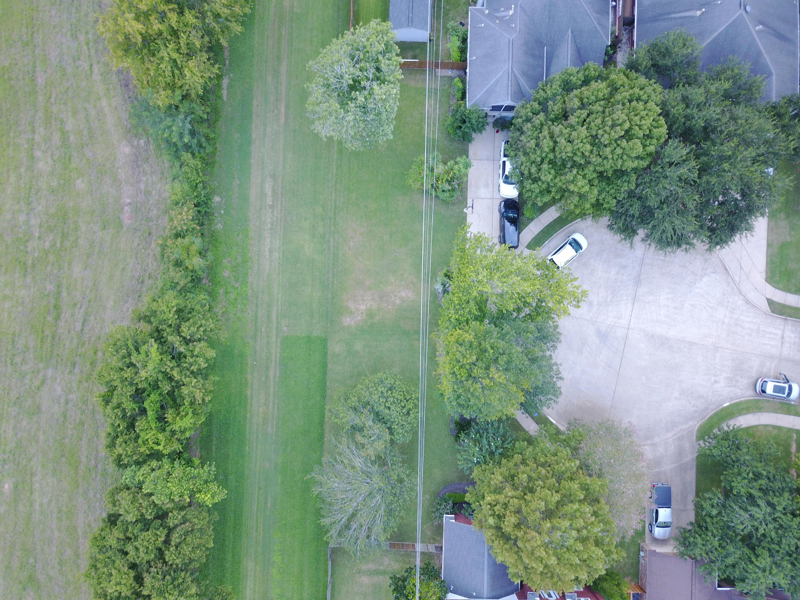

In [94]:
from PIL import Image

# img_number = 6802
# set_name = 'training'

# img_number = 6421
# set_name = 'training'

# img_number = 6467
# set_name = 'training'

# img_number = 6462
# set_name = 'validation'

# img_number = 10817
# set_name = 'validation'

img_number = 9723
set_name = 'validation'

PATH_to_mask = f"/content/Hurricane_Harvey/processed/{set_name}/annotation/{img_number}.png"
PATH_to_image = f"/content/Hurricane_Harvey/processed/{set_name}/images/{img_number}.tif"

mask_img_raw = Image.open(PATH_to_mask)
image = Image.open(PATH_to_image)
basewidth = 800
wpercent = (basewidth/float(image.size[0]))
hsize = int((float(image.size[1])*float(wpercent)))
image.resize((basewidth,hsize))

In [95]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoding = feature_extractor(image, return_tensors="pt")
pixel_values = encoding.pixel_values.to(device)

# forward pass
model.eval()
model.to(device)
outputs = model(pixel_values=pixel_values)

In [96]:
# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 27, 128, 128])


In [97]:
def give_palette():
    """ palette that maps each class to RGB values."""
    return [[0, 0, 0], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224]]

def right_wrong_pallete():
    """ palette that maps each class to RGB values."""
    return [[255, 255, 255], [0, 0, 255]]          

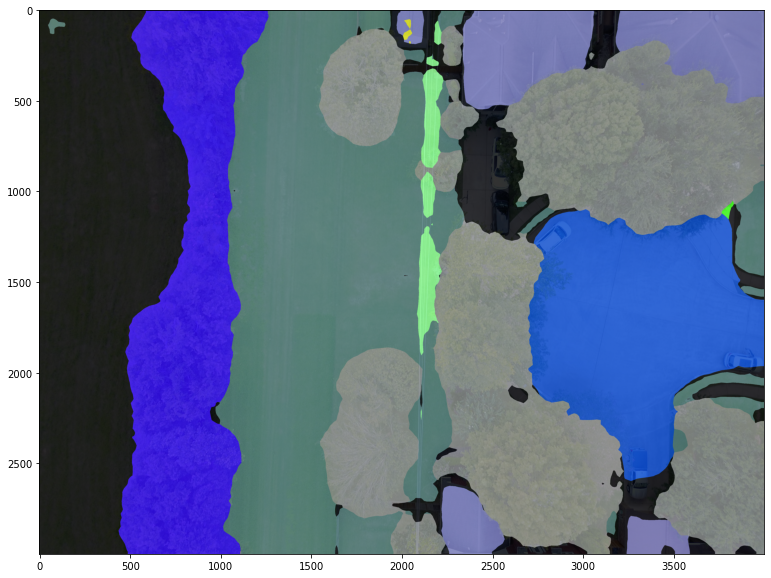

In [98]:
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(logits,
                size=image.size[::-1], # (height, width)
                mode='bilinear',
                align_corners=False)

# Second, apply argmax on the class dimension
seg = upsampled_logits.argmax(dim=1)[0]
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(give_palette())
for label, color in enumerate(palette):
    color_seg[seg == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.2 + color_seg * 0.8
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

In [99]:
mask_img = np.array(mask_img_raw)
classes = seg.numpy()

# Places where they dont match
classification_mask = mask_img !=classes

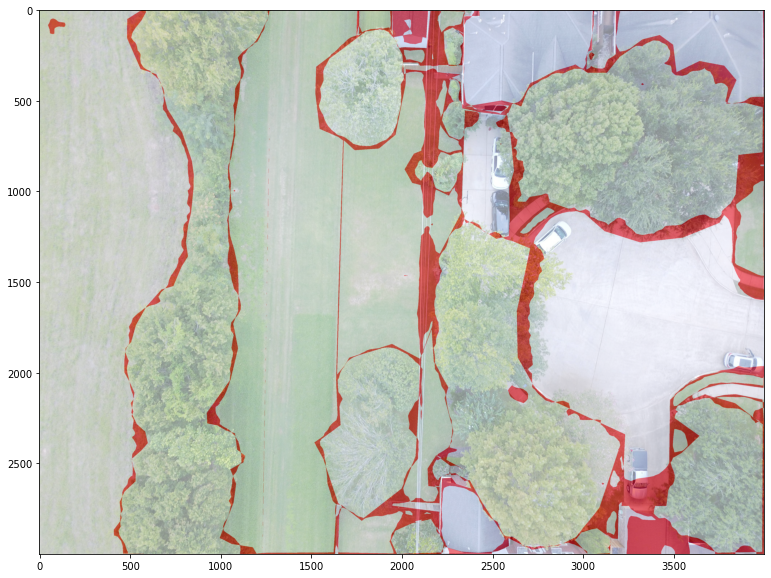

In [100]:
# Second, apply argmax on the class dimension
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(right_wrong_pallete())
for label, color in enumerate(palette):
    color_seg[classification_mask == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

In [101]:
from torchmetrics import Dice
dice = Dice(average='micro',ignore_index = 0)
tensor1 = torch.from_numpy(mask_img)
tensor2 = torch.from_numpy(classes)
dice(tensor1, tensor2)

tensor(0.9155)

# Training model on full data

In [ ]:
!rm -rf /content/Hurricane_Harvey/processed_all_training/

In [103]:
create_dir_if_not_exists(PATH + '/processed_all_training')
create_dir_if_not_exists(PATH + '/processed_all_training/training')
create_dir_if_not_exists(PATH + '/processed_all_training/training/images')
create_dir_if_not_exists(PATH + '/processed_all_training/training/annotation')

In [104]:
for i in tqdm(os.listdir(PATH + IMAGES_path)):
  if 'tif' not in i:
    continue
  image_number = i.split(".")[0]
  if((image_number in train_images) or (image_number in val_images)):
    # copying img
    src_path = PATH + IMAGES_path + "/" + image_number + '.tif'
    dst_path = PATH + "/processed_all_training/training/images/" + image_number + '.tif'
    shutil.copy(src_path, dst_path)
    # copying anotaion
    src_path = PATH + MASKS_path + "/" + image_number + '.png'
    dst_path = PATH + "/processed_all_training/training/annotation/" + image_number + '.png'
    shutil.copy(src_path, dst_path)

100%|██████████| 375/375 [00:01<00:00, 237.89it/s]


In [108]:
root_dir = PATH + '/processed_all_training'

train_dataset = SemanticSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, type_="training")
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [114]:
# Path to save model
PATH_to_save_model = "/content/drive/MyDrive/FDL/Group_work/Final_model/"

# Setting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loss
focal_loss = FocalLoss(alpha = 0.25,
                       reduction = "mean")

# Setting calculation of dice coef
dice_coef = Dice(average='micro',
                 zero_division = 0.00001, 
                 ignore_index = 0)

# Learning _ rate
lr = 0.00005

# Epochs
epochs = 40

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), 
                              lr=lr)


In [113]:
# Complete the hyperparams dict with the infos of your run
hyperparams = {"Model type" : model_name,
               "Batch size": batch_size,
               "Learning rate": lr,
               "Epochs": epochs}
               
# Init the WandB run with hyperparams
wandb.init(config=hyperparams,
           name = "All data",
           project=project_name)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [115]:
#move model to GPU
model.to(device)

num_batches_train = math.ceil(len(train_dataloader))
best_dice = 0 

In [116]:
for epoch in range(epochs):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   # TRAINING
   model.train()
   total_train_dice = []
   for idx, batch in enumerate(tqdm(train_dataloader)):

        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, 
                        labels=labels)
        loss_mse, logits = outputs.loss, outputs.logits
        logits = outputs.logits

        # calculating loss
        predicted = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)

        loss = focal_loss(predicted, labels)

        loss.backward()
        optimizer.step()
        
        # calculating additional metrics
        with torch.no_grad():
          predicted = predicted.argmax(dim=1)
          dice_coef_value = dice_coef(predicted.detach().cpu(),
                                     labels.detach().cpu())
          
          total_train_dice.append(dice_coef_value.item())

        wandb.log({"train_mse":loss_mse.item(),
                   "train_loss":loss.item(),
                   "train_dice_coef":dice_coef_value.item(),
                   "step2":num_batches_train*epoch+idx+1})

   # LOGGING PER BATCH INFO           
   wandb.log({"train_per_epoch_dice":mean(total_train_dice)})
        
   # CHECKPOINTING EVERY 10 epochs
   if (epoch +1) % 10 == 0:
       PATH_to_model = PATH_to_save_model + f"model_final_{epoch+1}.pt"
       torch.save({
                  'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict()
                  }, PATH_to_model)

Epoch: 0


100%|██████████| 75/75 [02:42<00:00,  2.17s/it]


Epoch: 1


100%|██████████| 75/75 [02:40<00:00,  2.14s/it]


Epoch: 2


100%|██████████| 75/75 [02:40<00:00,  2.14s/it]


Epoch: 3


100%|██████████| 75/75 [02:39<00:00,  2.13s/it]


Epoch: 4


100%|██████████| 75/75 [02:40<00:00,  2.14s/it]


Epoch: 5


100%|██████████| 75/75 [02:39<00:00,  2.12s/it]


Epoch: 6


100%|██████████| 75/75 [02:40<00:00,  2.14s/it]


Epoch: 7


100%|██████████| 75/75 [02:38<00:00,  2.11s/it]


Epoch: 8


100%|██████████| 75/75 [02:40<00:00,  2.14s/it]


Epoch: 9


100%|██████████| 75/75 [02:39<00:00,  2.13s/it]


Epoch: 10


100%|██████████| 75/75 [02:41<00:00,  2.15s/it]


Epoch: 11


100%|██████████| 75/75 [02:41<00:00,  2.15s/it]


Epoch: 12


100%|██████████| 75/75 [02:39<00:00,  2.13s/it]


Epoch: 13


100%|██████████| 75/75 [02:40<00:00,  2.14s/it]


Epoch: 14


100%|██████████| 75/75 [02:39<00:00,  2.12s/it]


Epoch: 15


100%|██████████| 75/75 [02:43<00:00,  2.18s/it]


Epoch: 16


100%|██████████| 75/75 [02:51<00:00,  2.29s/it]


Epoch: 17


100%|██████████| 75/75 [02:40<00:00,  2.15s/it]


Epoch: 18


100%|██████████| 75/75 [02:39<00:00,  2.13s/it]


Epoch: 19


100%|██████████| 75/75 [02:41<00:00,  2.15s/it]


Epoch: 20


100%|██████████| 75/75 [02:41<00:00,  2.15s/it]


Epoch: 21


100%|██████████| 75/75 [02:39<00:00,  2.13s/it]


Epoch: 22


100%|██████████| 75/75 [02:40<00:00,  2.13s/it]


Epoch: 23


100%|██████████| 75/75 [02:38<00:00,  2.12s/it]


Epoch: 24


100%|██████████| 75/75 [02:40<00:00,  2.14s/it]


Epoch: 25


100%|██████████| 75/75 [02:39<00:00,  2.12s/it]


Epoch: 26


100%|██████████| 75/75 [02:40<00:00,  2.14s/it]


Epoch: 27


100%|██████████| 75/75 [02:38<00:00,  2.12s/it]


Epoch: 28


100%|██████████| 75/75 [02:40<00:00,  2.13s/it]


Epoch: 29


100%|██████████| 75/75 [02:39<00:00,  2.12s/it]


Epoch: 30


100%|██████████| 75/75 [02:39<00:00,  2.13s/it]


Epoch: 31


100%|██████████| 75/75 [02:38<00:00,  2.11s/it]


Epoch: 32


100%|██████████| 75/75 [02:38<00:00,  2.11s/it]


Epoch: 33


100%|██████████| 75/75 [02:39<00:00,  2.12s/it]


Epoch: 34


100%|██████████| 75/75 [02:38<00:00,  2.11s/it]


Epoch: 35


100%|██████████| 75/75 [02:39<00:00,  2.13s/it]


Epoch: 36


100%|██████████| 75/75 [02:39<00:00,  2.12s/it]


Epoch: 37


100%|██████████| 75/75 [02:39<00:00,  2.12s/it]


Epoch: 38


100%|██████████| 75/75 [02:39<00:00,  2.12s/it]


Epoch: 39


100%|██████████| 75/75 [02:39<00:00,  2.13s/it]


# Utilties

## Connecting to WANDB

In [26]:
# Then connect to your W&B account
def wandb_connect():
    wandb_api_key_label = "wandb_api_key"
    wandb_api_key = "87a5a1ff6eff3552d163ad0e7caa719b96bb04b0" # here use your API key from WandB interface

    wandb_conx = wandb.login(key = wandb_api_key)
    print(f"Connected to Wandb online interface : {wandb_conx}")

wandb_connect()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Connected to Wandb online interface : True


In [ ]:
# Complete the hyperparams dict with the infos of your run
hyperparams = {"Batch size":4,
               "Learning rate":"-",
               "Epochs":"-"}
               
# Init the WandB run with hyperparams
wandb.init(config=hyperparams,
           project="FDP-group_work")

wandb: Currently logged in as: lpszenny (pszenny_t). Use `wandb login --relogin` to force relogin


## Save model

In [ ]:
PATH_to_model = "/content/drive/MyDrive/FDL/Group_work/SegFormer_b0/model_final.pt"
torch.save({
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict()
          }, PATH_to_model)

## Load Model

In [31]:
PATH_to_model = "/content/drive/MyDrive/FDL/Group_work/SegFormer_v10/best_model.pt"

checkpoint = torch.load(PATH_to_model)
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

<All keys matched successfully>

## Clear GPU cache

In [132]:
device = cuda.get_current_device()
device.reset()

## Making predictions on test set

In [117]:
create_dir_if_not_exists(PATH + '/new')
create_dir_if_not_exists(PATH + '/new/test_mask_dir')

In [118]:
from PIL import Image
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

mode = "bilinear"
PATH_with_test = "/content/Hurricane_Harvey/processed/test/images"
PATH_output = PATH + '/new/test_mask_dir/'

for file_ in tqdm(os.listdir(PATH_with_test)):
  image = Image.open(PATH_with_test+"/"+file_)
  encoding = feature_extractor(image, return_tensors="pt")
  pixel_values = encoding.pixel_values.to(device)
  outputs = model(pixel_values=pixel_values) #use for b0 model
  #outputs = model(pixel_values) #use for own decoder
  logits = outputs.logits.cpu()  #use for b0 model
  #logits = outputs.cpu()
  upsampled_logits = nn.functional.interpolate(logits,
                size=image.size[::-1], # (height, width)
                mode=mode)
  seg = upsampled_logits.argmax(dim=1)[0]

  file_number = file_.split(".")[0]

  image = Image.fromarray(seg.numpy().astype(np.uint32))
  image.save(PATH_output + file_number + '.png', format='PNG')


100%|██████████| 75/75 [04:29<00:00,  3.59s/it]


In [119]:
import tarfile  

tar = tarfile.open("submission.tar", "w")  
for root, dir, files in os.walk('/content/Hurricane_Harvey/new/test_mask_dir'):
	for  file in tqdm(files):
		fullpath = os.path.join(root, file)
		tar.add(fullpath, arcname=file)
tar.close()

100%|██████████| 75/75 [00:00<00:00, 2981.79it/s]


In [26]:
!zip -r submission.zip submission.tar

  adding: submission.tar (deflated 15%)


In [121]:
!rm -rf /content/Hurricane_Harvey/new/

# Loss : Focal - own decoder architecture


In [47]:
#best b0 SegFormer trained on Focal loss with image normalization needs to be loaded in memory

img_number = 6802
set_name = 'training'

PATH_to_image = f"/content/Hurricane_Harvey/processed/{set_name}/images/{img_number}.tif"
image = Image.open(PATH_to_image)

encoding = feature_extractor(image, return_tensors="pt")
x = encoding.pixel_values.to(device)

encoder = model.segformer.to(device)
encoder.eval()
encoded_info = encoder(x, output_hidden_states = True)

In [50]:
encoded_info.hidden_states[0].shape

torch.Size([1, 32, 128, 128])

In [51]:
encoded_info.hidden_states[1].shape

torch.Size([1, 64, 64, 64])

In [52]:
encoded_info.hidden_states[2].shape

torch.Size([1, 160, 32, 32])

In [53]:
encoded_info.hidden_states[3].shape

torch.Size([1, 256, 16, 16])

In [92]:
class Custom_model(nn.Module):
    def __init__(self, encoder, number_of_classes):
      super(Custom_model, self).__init__()
      self.encoder = encoder
      self.upsample = torch.nn.UpsamplingBilinear2d(scale_factor=2)
      self.gelu = torch.nn.GELU()

      self.conv3x3_stage_1 = nn.Conv2d(256, 128, kernel_size=3,padding=1)
      self.conv3x3_stage_2 = nn.Conv2d(288, 144, kernel_size=3,padding=1)
      self.conv3x3_stage_3 = nn.Conv2d(208, 104, kernel_size=3,padding=1)
      self.conv3x3_stage_4 = nn.Conv2d(136, 52, kernel_size=3,padding=1)
      self.conv3x3_stage_5 = nn.Conv2d(52, 52, kernel_size=3,padding=1)

      self.conv1x1 = nn.Conv2d(52, number_of_classes, kernel_size=1)
                            
    def forward(self, x):
      all_hidden_states = self.encoder(x, output_hidden_states = True)

      hidden_state_4 = all_hidden_states.hidden_states[3]
      hidden_state_3 = all_hidden_states.hidden_states[2]
      hidden_state_2 = all_hidden_states.hidden_states[1]
      hidden_state_1 = all_hidden_states.hidden_states[0]

      # Stage 1
      x = self.upsample(hidden_state_4)
      x = self.conv3x3_stage_1(x)
      x = self.gelu(x)
      x = torch.cat((x, hidden_state_3), 1)

      # Stage 2
      x = self.upsample(x)
      x = self.conv3x3_stage_2(x)
      x = self.gelu(x)
      x = torch.cat((x, hidden_state_2), 1)

      # Stage 3
      x = self.upsample(x)
      x = self.conv3x3_stage_3(x)
      x = self.gelu(x)
      x = torch.cat((x, hidden_state_1), 1)

      # Stage 4
      x = self.upsample(x)
      x = self.conv3x3_stage_4(x)
      x = self.gelu(x)

      # Stage 5
      x = self.upsample(x)
      x = self.conv3x3_stage_5(x)
      x = self.gelu(x)

      # Final pred
      x = self.conv1x1(x)

      return x

In [94]:
encoder = model.segformer.to(device)
model = Custom_model(encoder = encoder, number_of_classes = num_of_classes).to(device)

In [95]:
# Global params
max_epochs = 30
project_name = "FloodNet_SegFormer"

In [96]:
# Path to save model
PATH_to_save_model = "/content/drive/MyDrive/FDL/Group_work/SegFormer_decoder_v1/"

# Setting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loss
focal_loss = FocalLoss(alpha = 0.25,
                       reduction = "mean")

# Setting calculation of dice coef
dice_coef = Dice(average='micro',
                 zero_division = 0.00001, 
                 ignore_index = 0)

# Learning _ rate
lr = 0.00005

# Epochs
epochs = max_epochs

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), 
                              lr=lr)
# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(optimizer, 
                                 mode = 'max',
                                 factor=0.1,
                                 threshold=0.001, 
                                 patience=10)

In [97]:
# Complete the hyperparams dict with the infos of your run
hyperparams = {"Model type" : model_name,
               "Batch size": batch_size,
               "Learning rate": lr,
               "Epochs": epochs}
               
# Init the WandB run with hyperparams
wandb.init(config=hyperparams,
           name = "own decoder",
           project=project_name)

step2,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███▁▁▁▂▂▂▂▃
train_dice_coef,▁▁▁▁▁▁▁▁▁▁▄▄▃▄▅▅▄▅▅▄▇▄▆▆▆▆▅▆▆▆▆█▅▆▇▆▆▅▆▆
train_loss,████████▇█▇▇▆▆▆▅▆▆▅▅▃▅▃▃▃▃▄▃▃▃▂▁▄▂▂▂▃▃▂▂
val_dice_coef,▃▁▂▂▄▄▄▇▇█▅▄▂▄▁
val_loss,▄▆▇▆▆▆▄▃▃▁▆▆▆▆█
step2,15
train_dice_coef,0.55959
train_loss,0.27136
val_dice_coef,0.48211
val_loss,0.38775


In [98]:
#move model to GPU
model.to(device)

num_batches_train = math.ceil(len(train_dataloader))
num_batches_val = math.ceil(len(valid_dataloader))
best_dice = 0 

In [99]:
for epoch in range(epochs):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   # TRAINING
   model.train()
   total_train_dice = []
   total_val_dice = []
   for idx, batch in enumerate(tqdm(train_dataloader)):

        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values)

        loss = focal_loss(outputs, labels)

        loss.backward()
        optimizer.step()
        
        # calculating additional metrics
        with torch.no_grad():
          predicted = outputs.argmax(dim=1)
          dice_coef_value = dice_coef(predicted.detach().cpu(),
                                     labels.detach().cpu())
          
          total_train_dice.append(dice_coef_value.item())

        wandb.log({"train_loss":loss.item(),
                   "train_dice_coef":dice_coef_value.item(),
                   "step2":num_batches_train*epoch+idx+1})
        
   # VALIDATION
   model.eval()
   with torch.no_grad():
       for idx, batch in enumerate(tqdm(valid_dataloader)):
           # get the inputs;
           pixel_values = batch["pixel_values"].to(device)
           labels = batch["labels"].to(device)
                     
           # prediction
           outputs = model(pixel_values)
           
           loss = focal_loss(outputs.detach(),
                             labels.detach())
           
           # Computing additional metrics
           predicted = outputs.argmax(dim=1)

           dice_coef_value = dice_coef(predicted.detach().cpu(),
                                       labels.detach().cpu())
           
           total_val_dice.append(dice_coef_value.item())

           wandb.log({"val_loss":loss.item(),
                      "val_dice_coef":dice_coef_value.item(),
                      "step2":num_batches_val*epoch+idx+1})

   # LOGGING PER BATCH INFO           
   wandb.log({"train_per_epoch_dice":mean(total_train_dice),
              "val_per_epoch_dice":mean(total_val_dice)})
   
   # Saving best model
   if mean(total_val_dice) > best_dice:
     best_dice = mean(total_val_dice)
     PATH_to_model = PATH_to_save_model + "best_model.pt"
     torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict()
          }, PATH_to_model)
     
   # LR SCHEDULER
   lr_scheduler.step(mean(total_val_dice))
   print('Learning rate: {}'.format(optimizer.state_dict()['param_groups'][0]['lr']))

   # CHECKPOINTING EVERY 10 epochs
   if (epoch +1) % 10 == 0:
       PATH_to_model = PATH_to_save_model + f"model_final_{epoch+1}.pt"
       torch.save({
                  'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict()
                  }, PATH_to_model)

Epoch: 0


100%|██████████| 15/15 [00:28<00:00,  1.89s/it]


Learning rate: 5e-05
Epoch: 1


100%|██████████| 15/15 [00:28<00:00,  1.89s/it]


Learning rate: 5e-05
Epoch: 2


100%|██████████| 15/15 [00:28<00:00,  1.89s/it]


Learning rate: 5e-05
Epoch: 3


100%|██████████| 15/15 [00:28<00:00,  1.88s/it]


Learning rate: 5e-05
Epoch: 4


100%|██████████| 15/15 [00:28<00:00,  1.89s/it]


Learning rate: 5e-05
Epoch: 5


100%|██████████| 15/15 [00:28<00:00,  1.88s/it]


Learning rate: 5e-05
Epoch: 6


100%|██████████| 15/15 [00:28<00:00,  1.91s/it]


Learning rate: 5e-05
Epoch: 7


100%|██████████| 15/15 [00:28<00:00,  1.88s/it]


Learning rate: 5e-05
Epoch: 8


100%|██████████| 15/15 [00:28<00:00,  1.89s/it]


Learning rate: 5e-05
Epoch: 9


100%|██████████| 15/15 [00:28<00:00,  1.88s/it]


Learning rate: 5e-05
Epoch: 10


100%|██████████| 15/15 [00:28<00:00,  1.89s/it]


Learning rate: 5e-05
Epoch: 11


100%|██████████| 15/15 [00:28<00:00,  1.88s/it]


Learning rate: 5e-05
Epoch: 12


100%|██████████| 15/15 [00:28<00:00,  1.89s/it]


Learning rate: 5e-05
Epoch: 13


100%|██████████| 15/15 [00:28<00:00,  1.89s/it]


Learning rate: 5e-05
Epoch: 14


100%|██████████| 15/15 [00:29<00:00,  1.96s/it]


Learning rate: 5e-05
Epoch: 15


100%|██████████| 15/15 [00:28<00:00,  1.89s/it]


Learning rate: 5e-05
Epoch: 16


100%|██████████| 15/15 [00:28<00:00,  1.87s/it]


Learning rate: 5e-05
Epoch: 17


100%|██████████| 15/15 [00:29<00:00,  1.94s/it]


Learning rate: 5e-05
Epoch: 18


100%|██████████| 15/15 [00:28<00:00,  1.88s/it]


Learning rate: 5e-05
Epoch: 19


100%|██████████| 15/15 [00:28<00:00,  1.87s/it]


Learning rate: 5e-05
Epoch: 20


100%|██████████| 15/15 [00:28<00:00,  1.88s/it]


Learning rate: 5e-05
Epoch: 21


100%|██████████| 15/15 [00:28<00:00,  1.89s/it]


Learning rate: 5e-05
Epoch: 22


100%|██████████| 15/15 [00:28<00:00,  1.88s/it]


Learning rate: 5e-05
Epoch: 23


100%|██████████| 15/15 [00:28<00:00,  1.87s/it]


Learning rate: 5e-05
Epoch: 24


100%|██████████| 15/15 [00:28<00:00,  1.87s/it]


Learning rate: 5e-05
Epoch: 25


100%|██████████| 15/15 [00:28<00:00,  1.88s/it]


Learning rate: 5e-05
Epoch: 26


100%|██████████| 15/15 [00:28<00:00,  1.88s/it]


Learning rate: 5e-05
Epoch: 27


100%|██████████| 15/15 [00:29<00:00,  1.96s/it]


Learning rate: 5e-05
Epoch: 28


100%|██████████| 15/15 [00:28<00:00,  1.88s/it]


Learning rate: 5e-05
Epoch: 29


100%|██████████| 15/15 [00:28<00:00,  1.89s/it]


Learning rate: 5e-05
